In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [3]:
fname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_final'}.xlsx")
cname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_case'}.xlsx")
lname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_law'}.xlsx")

dff = pd.read_excel(fname, index_col=0)
dfc = pd.read_excel(cname, index_col=0)
dfl = pd.read_excel(lname, index_col=0)

df = pd.concat([dff[['text', 'y_sentence']], dfc[1:], dfl[1:]], axis=1).reindex(dff.index)
df = df.dropna(subset=['y_sentence'])
df = df[df['y_sentence'] < 481] #살인 및 무기징역 제외

In [4]:
X = df.drop('y_sentence', axis=1)
y = df['y_sentence']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
X1_train = X_train[dfc.columns[1:]]
X1_test = X_test[dfc.columns[1:]]

X2_train = X_train[dfl.columns[1:]]
X2_test = X_test[dfl.columns[1:]]

In [7]:
X3_train = list(X_train["text"])
X3_test = list(X_test["text"])

max_features = 30000
sequence_length = 256

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(X3_train)

X3_train = tokenizer.texts_to_sequences(X3_train)
X3_test = tokenizer.texts_to_sequences(X3_test)

X3_train = tf.keras.preprocessing.sequence.pad_sequences(X3_train, sequence_length)
X3_test = tf.keras.preprocessing.sequence.pad_sequences(X3_test, sequence_length)

In [8]:
input_1 = tf.keras.Input(dtype = tf.float32, shape = (len(dfc.columns[1:]),))
input_2 = tf.keras.Input(dtype = tf.float32, shape = (len(dfl.columns[1:]),))

dense_layer_1_1 = tf.keras.layers.Dense(units = 20, activation = tf.nn.relu)(input_1)
dense_layer_1_2 = tf.keras.layers.Dense(units = 20, activation = tf.nn.relu)(dense_layer_1_1)
dense_layer_1_3 = tf.keras.layers.Dense(units = 20, activation = tf.nn.relu)(dense_layer_1_2)
dense_layer_1_4 = tf.keras.layers.Dense(units = 20, activation = tf.nn.relu)(dense_layer_1_3)
dropout_1_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_1_3)


dense_layer_2_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_2)
dense_layer_2_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_1)
dense_layer_2_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_2)
dense_layer_2_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_3)
dropout_2_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_2_3)

In [9]:
embeddings_index = {}
f = open(os.path.join(os.path.dirname(os.getcwd()), 'data_processing', 'ft_0825_6.txt'),  encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

word_index = tokenizer.word_index

num_words = min(max_features, len(word_index)) + 1
print(num_words)
embedding_dim = 200
num_filters = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

25350


In [10]:
input_3 = tf.keras.Input(dtype = tf.float32, shape = (sequence_length,))
embedding_layer_3 = tf.keras.layers.Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(input_3)

reshape_3 = tf.keras.layers.Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)

conv_0_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, embedding_dim), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_1_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(4, embedding_dim), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_2_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(5, embedding_dim), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)

maxpool_0_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)
maxpool_1_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_3)
maxpool_2_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_3)

concatenated_tensor_3 = tf.keras.layers.Concatenate(axis=1)([maxpool_0_3, maxpool_1_3, maxpool_2_3])
flatten_3 = tf.keras.layers.Flatten()(concatenated_tensor_3)
dropout_3 = tf.keras.layers.Dropout(rate = 0.5)(flatten_3)

In [11]:
concat_layer = tf.keras.layers.Concatenate()([dropout_1_5, dropout_2_5, dropout_3])


dense_layer_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(concat_layer)
dense_layer_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_3)
dense_layer_5 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4)
dense_layer_6 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_5)

output = tf.keras.layers.Dense(units = 1, activation = tf.nn.relu)(dense_layer_4)

model = tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=output)

In [12]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adamax(learning_rate=0.005), metrics=['mse', 'mae'])
print(model.summary())
#Adamax

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 200)     5070000     input_3[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 256, 200, 1)  0           embedding[0][0]                  
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 153)]        0                                            
______________________________________________________________________________________________

In [13]:
history = model.fit(x=[X1_train, X2_train, X3_train], y=y_train, batch_size=32, epochs=200, verbose=1, validation_split=0.1)

Train on 3705 samples, validate on 412 samples
Epoch 1/200
3705/3705 [==============================] - 8s 2ms/sample - loss: 1479.1090 - mse: 1295.3695 - mae: 19.0905 - val_loss: 1202.7193 - val_mse: 972.1707 - val_mae: 16.7481
Epoch 2/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 1033.3167 - mse: 786.9960 - mae: 15.0328 - val_loss: 1080.4848 - val_mse: 813.8378 - val_mae: 15.6375
Epoch 3/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 867.8314 - mse: 582.0089 - mae: 13.7367 - val_loss: 979.6765 - val_mse: 687.4904 - val_mae: 13.9988
Epoch 4/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 768.8071 - mse: 475.4012 - mae: 12.6699 - val_loss: 923.6243 - val_mse: 622.0351 - val_mae: 12.7472
Epoch 5/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 639.6169 - mse: 335.7777 - mae: 11.2358 - val_loss: 928.4582 - val_mse: 625.7589 - val_mae: 12.4524
Epoch 6/200
3705/3705 [==============================

3705/3705 [==============================] - 4s 1ms/sample - loss: 334.5336 - mse: 165.4797 - mae: 7.9510 - val_loss: 700.3751 - val_mse: 536.7632 - val_mae: 12.0933
Epoch 47/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 324.4389 - mse: 165.8577 - mae: 7.9113 - val_loss: 633.7477 - val_mse: 472.5470 - val_mae: 11.5226
Epoch 48/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 312.7816 - mse: 157.0836 - mae: 7.7734 - val_loss: 644.2763 - val_mse: 486.5621 - val_mae: 11.6476
Epoch 49/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 327.1215 - mse: 170.4893 - mae: 7.9365 - val_loss: 647.2807 - val_mse: 487.2150 - val_mae: 11.3345
Epoch 50/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 335.6269 - mse: 172.5599 - mae: 8.1635 - val_loss: 679.0367 - val_mse: 512.9401 - val_mae: 11.5658
Epoch 51/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 337.6211 - mse: 174.7916 - mae: 7.8995

Epoch 92/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 255.3547 - mse: 132.2859 - mae: 6.6845 - val_loss: 610.0280 - val_mse: 491.1328 - val_mae: 11.7519
Epoch 93/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 257.6205 - mse: 138.1244 - mae: 6.8965 - val_loss: 633.3739 - val_mse: 506.5268 - val_mae: 12.1966
Epoch 94/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 243.8542 - mse: 121.3896 - mae: 6.7042 - val_loss: 601.5348 - val_mse: 478.2073 - val_mae: 11.8202
Epoch 95/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 242.8384 - mse: 123.6203 - mae: 6.5808 - val_loss: 579.6039 - val_mse: 459.6842 - val_mae: 11.2132
Epoch 96/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 251.2435 - mse: 132.8014 - mae: 6.7497 - val_loss: 642.7302 - val_mse: 520.0953 - val_mae: 11.6009
Epoch 97/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 251.8898 - mse: 128.9057 

3705/3705 [==============================] - 4s 1ms/sample - loss: 207.5493 - mse: 102.9978 - mae: 6.0596 - val_loss: 569.6497 - val_mse: 464.5415 - val_mae: 11.2480
Epoch 138/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 196.1085 - mse: 92.5416 - mae: 5.9491 - val_loss: 570.0968 - val_mse: 466.7929 - val_mae: 11.3952
Epoch 139/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 209.9604 - mse: 105.7682 - mae: 5.9448 - val_loss: 549.0848 - val_mse: 446.1067 - val_mae: 11.2981
Epoch 140/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 211.0322 - mse: 111.3355 - mae: 6.0697 - val_loss: 557.7156 - val_mse: 458.1178 - val_mae: 11.1568
Epoch 141/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 212.8046 - mse: 112.1036 - mae: 5.9695 - val_loss: 534.7649 - val_mse: 434.3702 - val_mae: 10.8217
Epoch 142/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 196.9978 - mse: 97.5438 - mae: 5.9

Epoch 183/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 178.1192 - mse: 90.6794 - mae: 5.5539 - val_loss: 555.2886 - val_mse: 469.7191 - val_mae: 11.0611
Epoch 184/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 174.2127 - mse: 88.4572 - mae: 5.6864 - val_loss: 538.8360 - val_mse: 451.2028 - val_mae: 11.4023
Epoch 185/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 170.2975 - mse: 86.5011 - mae: 5.5409 - val_loss: 617.7146 - val_mse: 534.2214 - val_mae: 11.8647
Epoch 186/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 165.8854 - mse: 82.3336 - mae: 5.4198 - val_loss: 550.5367 - val_mse: 465.7835 - val_mae: 11.7054
Epoch 187/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 172.1005 - mse: 85.9149 - mae: 5.5726 - val_loss: 581.7702 - val_mse: 494.0480 - val_mae: 11.8850
Epoch 188/200
3705/3705 [==============================] - 4s 1ms/sample - loss: 186.1776 - mse: 100.1869

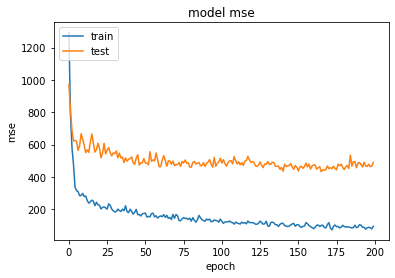

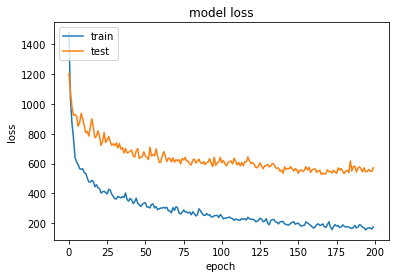

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [15]:
score = model.evaluate(x=[X1_test, X2_test, X3_test], y=y_test, verbose=1)

print(score)
#print("Test Score:", score[0])
print("Test MSE:", score[1])
print("Test MAE: ", score[2])

458/458 [==============================] - 0s 547us/sample - loss: 579.1868 - mse: 496.4306 - mae: 11.3705
[579.1867827702818, 496.43057, 11.370537]
Test MSE: 496.43057
Test MAE:  11.370537


In [16]:
# fasttext 에폭 1000 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.02, seqeunce length 256, 최대형량480, embedding 200 
# 20-20-20//10-10-10//10 배치 32, 에폭 200, admax 0.005, 판사 없이, case 0.5: 695 644 680 741 674 656//에폭300: 817 <================
# 20-20-20//10-10-10//10-10배치 32, 에폭 200, admax 0.005, 판사 없이, case 0.5: 





#데이터 추가
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, RMSprop 0.0001, 판사 없이, case 0.5: 668
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, RMSprop 0.0005, 판사 없이, case 0.5: 589
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, RMSprop 0.001, 판사 없이, case 0.5: 633
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, RMSprop 0.005, 판사 없이, case 0.5: 765

# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.001, 판사 없이, case 0.5: 1795
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.01, 판사 없이, case 0.5: 1250
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.05, 판사 없이, case 0.5:786
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.1, 판사 없이, case 0.5: 661
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.2, 판사 없이, case 0.5: 622
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.2, 판사 없이, case 0.5: 603
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.5, 판사 없이, case 0.5: 573 592 591 578
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.6, 판사 없이, case 0.5: 570 557 
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 554 576 545 565 547 557 
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.8, 판사 없이, case 0.5: 583


# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adagrad 0.001, 판사 없이, case 0.5: 976// 오버피팅 없음
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adagrad 0.005, 판사 없이, case 0.5: 676
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adagrad 0.01, 판사 없이, case 0.5: 637

# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adam 0.0001, 판사 없이, case 0.5: 714
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adam 0.0005, 판사 없이, case 0.5: 643
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adam 0.001, 판사 없이, case 0.5: 733
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adam 0.005, 판사 없이, case 0.5: 976

# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adamax 0.0005, 판사 없이, case 0.5: 690
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adamax 0.001, 판사 없이, case 0.5: 662
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adamax 0.005, 판사 없이, case 0.5: 614 620 663// 오버피팅 없음
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adamax 0.008, 판사 없이, case 0.5: 598 658 
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adamax 0.01, 판사 없이, case 0.5: 675

# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Nadam 0.0001, 판사 없이, case 0.5: 723
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Nadam 0.0005, 판사 없이, case 0.5: 583
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Nadam 0.001, 판사 없이, case 0.5: 634
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Nadam 0.005, 판사 없이, case 0.5: 771

# fasttext 에폭 10 
# 10-10-10//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 604
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 574 557 580// 갭은 줄어 보임
# 법 4 미만 제외
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5:558 569 584// 그래프 더 그럴싸해짐
# 법 10 미만 제외
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 622
# 법 4 미만 제외, 케이스 4 미만 제외
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 565
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.8: 589
# 법 2 미만 제외, 케이스 2 미만 제외
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 627
# => tf-idf 0.01
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 714
# => tf-idf 0.04, seqeunce length 64 
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 722

# fasttext 에폭 10 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.02, seqeunce length 93
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 795
# fasttext 에폭 10 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.02, seqeunce length 300
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 600 // 그래프가 안 줄어들음
# fasttext 에폭 10 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.02, seqeunce length 128, 최대형량480
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 905
# fasttext 에폭 10 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.02, seqeunce length 94, 최대형량480
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 948
# fasttext 에폭 10 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.02, seqeunce length 392, 최대형량480
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 971
# fasttext 에폭 10 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.02, seqeunce length 128, 최대형량480, embedding 300
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 919
# fasttext 에폭 10 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.02, seqeunce length 128, 최대형량480, embedding 200 
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 909
# fasttext 에폭 10 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.02, seqeunce length 300, 최대형량480, embedding 200
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 948
# fasttext 에폭 10 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.02, seqeunce length 100, 최대형량480, embedding 200
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 967

# fasttext 에폭 10 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.05, seqeunce length 64, 최대형량480, embedding 200
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 1360
# fasttext 에폭 10 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.05, seqeunce length 128, 최대형량480, embedding 200
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 1302

# fasttext 에폭 10 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.005, seqeunce length 128, 최대형량480, embedding 200
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 949
# fasttext 에폭 1000 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.005, seqeunce length 128, 최대형량480, embedding 200
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 886

#사건 수정
# fasttext 에폭 1000 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.02, seqeunce length 128, 최대형량480, embedding 200 
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 829
# fasttext 에폭 1000 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.02, seqeunce length 128, 최대형량480, embedding 200 
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5: 

# fasttext 에폭 1000 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.02, seqeunce length 128, 최대형량480, embedding 200 
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, admax 0.005, 판사 없이, case 0.5: 734 //그래프 더 괜찮음 에폭 150: 726 에폭200:708
# fasttext 에폭 1000 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.02, seqeunce length 94, 최대형량480, embedding 200 
# 20-20-20//10-10-10//10-10 배치 32, 에폭 200, admax 0.005, 판사 없이, case 0.5: 690 722


# fasttext 에폭 1000 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.02, seqeunce length 256, 최대형량480, embedding 200 
# 20-20-20//10-10-10//10-10 배치 32, 에폭 200, admax 0.005, 판사 없이, case 0.5, 마지막 10하나: 
# fasttext 에폭 1000 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.02, seqeunce length 256, 최대형량480, embedding 200 
# 20-20-20//10-10-10//10-10 배치 32, 에폭 200, admax 0.005, 판사 없이, case 0.5, 마지막 10하나, 전체 drop 0.5: 






# fasttext 에폭 1000 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.02, seqeunce length 256, 최대형량480, embedding 200 
# 20-20-20//10-10-10//10-10 배치 32, 에폭 200, admax 0.001, 판사 없이, case 0.5:743

# fasttext 에폭 1000 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.02, seqeunce length 256, 최대형량480, embedding 200 
# 20-20-20//10-10-10//10-10 배치 2, 에폭 200, admax 0.005, 판사 없이, case 0.5: 797
# fasttext 에폭 1000 ,법 4 미만 제외, 케이스 4 미만 제외, tf-idf 0.02, seqeunce length 256, 최대형량480, embedding 200 
# 20-20-20//10-10-10//10-10 배치 2, 에폭 200, ndam 0.0005, 판사 없이, case 0.5: 679 <===========


# fasttext 에폭 100
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5:605 606 

# fasttext 에폭 10 , window 2
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.7, 판사 없이, case 0.5:591 574


In [17]:
#tf-idf 0.2
#10-10-10-10 배치 16, 에폭 100, Adamax 0.001: 393 392 <===
#50-10-10-10 배치 16, 에폭 100, Adamax 0.001: 528
#100-100-100-100 배치 16, 에폭 100, Adamax 0.001: 813
#8-8-8-8 배치 16, 에폭 100, Adamax 0.001: 407
#12-12-12-12 배치 16, 에폭 100, Adamax 0.001: 616

#10-10-10-10 배치 2, 에폭 100, Adamax 0.001: 594
#10-10-10-10 배치 32, 에폭 100, Adamax 0.001:358 364 <== 에폭 50: 360 358 
#10-10-10-10 배치 64, 에폭 100, Adamax 0.001: 374
#10-10-10-10 배치 128, 에폭 100, Adamax 0.001: 369

#10-10-10-10 배치 32, 에폭 100, Adamax 0.0001: 505// 에폭 200: 425// 에폭 300: 387// 에폭 400: 371// 에폭 500:371 // 에폭 600: 367
#10-10-10-10 배치 32, 에폭 100, Adamax 0.0005: 362 363기울기가 더 그럴 듯 하다. // 에폭 200 : 359 
#10-10-10-10 배치 32, 에폭 100, Adamax 0.005: 435
#10-10-10-10 배치 32, 에폭 100, Adamax 0.01: 586


#10-10-10-10 배치 32, 에폭 100, Adam 0.001: 461 그래프 못 생김

#10-10-10-10 배치 32, 에폭 100, Adamax 0.0005, 판사 없이: 346 344 343 //애폭 120: 341 370//에폭150: 347 365 361 //에폭 400: 414
#10-10-10-10 배치 32, 에폭 100, Adamax 0.001, 판사 없이: 350 // 에폭400: 534
#10-10-10-10 배치 32, 에폭 100, RMSProp 0.001, 판사 없이: 621
#10-10-10-10 배치 32, 에폭 100, RMSProp 0.0005, 판사 없이: 664
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.001, 판사 없이: 779 //에폭200: 703
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.01, 판사 없이:580 
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.1, 판사 없이: 408
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.15, 판사 없이: 368
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.2, 판사 없이: 329 334 334 334 335<==================에폭 120: 363// 에폭 80: 351
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.25, 판사 없이: 405
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.3, 판사 없이: 360 360 365 

#10-10-10-10 배치 32, 에폭 100, Adagrad 0.001, 판사 없이: 498
#10-10-10-10 배치 32, 에폭 100, Adagrad 0.005, 판사 없이: 412
#10-10-10-10 배치 32, 에폭 100, Adagrad 0.01, 판사 없이: 394
#10-10-10-10 배치 32, 에폭 100, Adagrad 0.05, 판사 없이: 404

#10-10-10-10 배치 32, 에폭 100, Nadam 0.005, 판사 없이: 494
#10-10-10-10 배치 32, 에폭 100, Nadam 0.001, 판사 없이: 504
#10-10-10-10 배치 32, 에폭 100, Nadam 0.0005, 판사 없이: 388
#10-10-10-10 배치 32, 에폭 100, Nadam 0.0001, 판사 없이: 406



#tf-idf 0.1
#10-10-10-10 배치 32, 에폭 100, Adamax 0.0005, 판사 없이: 687

#마지막 10 에러 고치고
#마지막 10-10-10-10 배치 32, 에폭 100, Adadelta 0.2, 판사 없이: 477
#마지막 10-10-10 배치 32, 에폭 100, Adadelta 0.2, 판사 없이: 488
#마지막 10-10 배치 32, 에폭 100, Adadelta 0.2, 판사 없이:367
#전체 10 -10 배치 32, 에폭 100, Adadelta 0.2, 판사 없이: 332 328 <===========================에폭200: 476
#10-10-(10) 배치 32, 에폭 100, Adadelta 0.2, 판사 없이: 338 336 332 330 <==============================에폭 120: 360
#512-512-(512) 배치 32, 에폭 100, Adadelta 0.2, 판사 없이: 926
#256-256-(256) 배치 32, 에폭 100, Adadelta 0.2, 판사 없이:884
#128-128-(128) 배치 32, 에폭 100, Adadelta 0.2, 판사 없이:880
#20-20-(20) 배치 32, 에폭 100, Adadelta 0.2, 판사 없이: 418
#50-10-(10) 배치 32, 에폭 100, Adadelta 0.2, 판사 없이: 497


#10-10-(10) 배치 32, 에폭 100, Adadelta 0.2, 판사 없이, case 0.6: 345 334 
#10-10-(10) 배치 32, 에폭 100, Adadelta 0.2, 판사 없이, case 0.5: 328 337 337



#사건 고친 후 0.5
#10-10-(10) 배치 32, 에폭 100, Adadelta 0.2, 판사 없이, case 0.5: 1235
#10-10-(10) 배치 32, 에폭 100, Adadelta 0.3, 판사 없이, case 0.5: 1285
#10-10-(10) 배치 32, 에폭 100, Adadelta 0.1, 판사 없이, case 0.5: 1275
#50-10-10//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.2, 판사 없이, case 0.5: 1259
#100-100-10//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.2, 판사 없이, case 0.5: 1249
#100-100-100//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.2, 판사 없이, case 0.5: 1265
#50-50-50//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.2, 판사 없이, case 0.5: 1220
#20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.2, 판사 없이, case 0.5: 1207
#10-10-10-10//10-10-10-10//10-10 배치 32, 에폭 100, Adadelta 0.2, 판사 없이, case 0.5: 1230


# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adagrad 0.001, 판사 없이, case 0.5: 1436
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adagrad 0.01, 판사 없이, case 0.5: 1242
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adagrad 0.02, 판사 없이, case 0.5: 1121
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adagrad 0.05, 판사 없이, case 0.5: 1070
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adagrad 0.1, 판사 없이, case 0.5: 1647

# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adam 0.0005, 판사 없이, case 0.5: 1169
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adam 0.001, 판사 없이, case 0.5: 1161
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adam 0.005, 판사 없이, case 0.5: 1151

# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adamax 0.0001, 판사 없이, case 0.5: 1429 // 에폭 150: 1360 에폭200: 1346
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adamax 0.0002, 판사 없이, case 0.5: 1333
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adamax 0.0005, 판사 없이, case 0.5: 1142 - 그래프 같이 내려감
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adamax 0.001, 판사 없이, case 0.5: 1163
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adamax 0.005, 판사 없이, case 0.5: 1153
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Adamax 0.01, 판사 없이, case 0.5: 


# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Nadam 0.0005, 판사 없이, case 0.5: 1174
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Nadam 0.001, 판사 없이, case 0.5: 1101
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, Nadam 0.005, 판사 없이, case 0.5: 1185


# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, RMSprop 0.0005, 판사 없이, case 0.5:1187 
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, RMSprop 0.001, 판사 없이, case 0.5: 982 
# 20-20-20//10-10-10//10-10 배치 32, 에폭 100, RMSprop 0.005, 판사 없이, case 0.5: 1045

# 20-20-20-20//10-10-10-10//10-10 배치 32, 에폭 100, RMSprop 0.001, 판사 없이, case 0.5: 1010
# 30-30-30-30//10-10-10-10//10-10 배치 32, 에폭 100, RMSprop 0.001, 판사 없이, case 0.5: 990
# 40-40-40-40//10-10-10-10//10-10 배치 32, 에폭 100, RMSprop 0.001, 판사 없이, case 0.5: 1101
